In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Path to the dataset
dataset_dir = '/content/drive/MyDrive/Soil Nitrogen Levels'

# Create lists to hold image paths and labels
image_paths = []
labels = []

# Walk through each class directory (Level 2, Level 3, Level 4, Level 5)
for label in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            # Append the image path and the corresponding label (class)
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(label)

# Convert the data into a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display first few rows of the dataset
print(data.head())


                                          image_path     label
0  /content/drive/MyDrive/Soil Nitrogen Levels/Le...  Level 03
1  /content/drive/MyDrive/Soil Nitrogen Levels/Le...  Level 04
2  /content/drive/MyDrive/Soil Nitrogen Levels/Le...  Level 05
3  /content/drive/MyDrive/Soil Nitrogen Levels/Le...  Level 03
4  /content/drive/MyDrive/Soil Nitrogen Levels/Le...  Level 02


In [ ]:
# Split the dataset (80% for training, 10% for validation, 10% for testing)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Save the split dataset to CSV files in Colab's local file system
train_data.to_csv('mareertrain_dataVGG1_80.csv', index=False)
val_data.to_csv('mareerval_dataVGG1_10.csv', index=False)
test_data.to_csv('mareertest_dataVGG1_10.csv', index=False)

# Display the shapes of training, validation, and testing sets
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Testing set: {test_data.shape}")


Training set: (608, 2)
Validation set: (76, 2)
Testing set: (76, 2)


In [ ]:
# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    brightness_range=[0.8, 1.2],
    channel_shift_range=30
)


# ImageDataGenerator for validation and testing (no augmentation, just rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load training data from the DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation data from the DataFrame
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load testing data from the DataFrame
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 608 validated image filenames belonging to 4 classes.
Found 76 validated image filenames belonging to 4 classes.
Found 76 validated image filenames belonging to 4 classes.


In [ ]:
# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers to the VGG16 model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Use the number of classes from train_generator's class_indices
num_classes = len(train_generator.class_indices)

# Add the final softmax layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional base of VGG16 to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use the new '.keras' format for saving the model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/mareerbest_modelVGG16.keras', monitor='val_loss', save_best_only=True)


In [ ]:
# Train the model with validation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,  # Adjust as needed
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 557s 18s/step - accuracy: 0.3039 - loss: 1.6264 - val_accuracy: 0.5938 - val_loss: 0.9519
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 887ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4167 - val_loss: 1.0794
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - accuracy: 0.5252 - loss: 0.9892 - val_accuracy: 0.7812 - val_loss: 0.6801
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.6372
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.6669 - loss: 0.8005 - val_accuracy: 0.6250 - val_loss: 0.6969
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6891
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.6525 - loss: 0.7499 - val_accuracy: 0.7031 - val_loss: 0.6326
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.5144
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.7261 - loss: 0.6464 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.8958 - loss: 0.4617
Test Loss: 0.45700955390930176, Test Accuracy: 0.90625


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


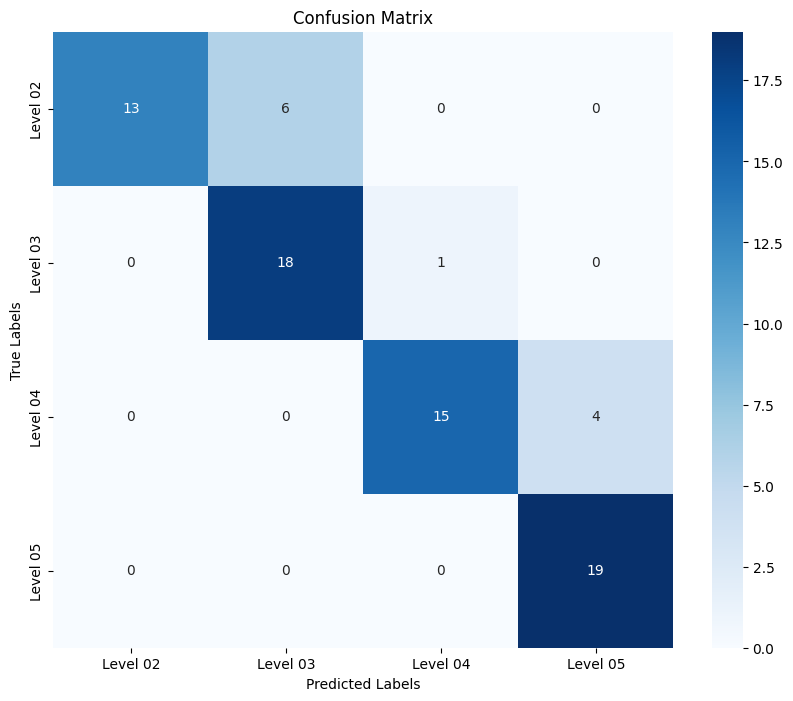

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class labels (for use in confusion matrix)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


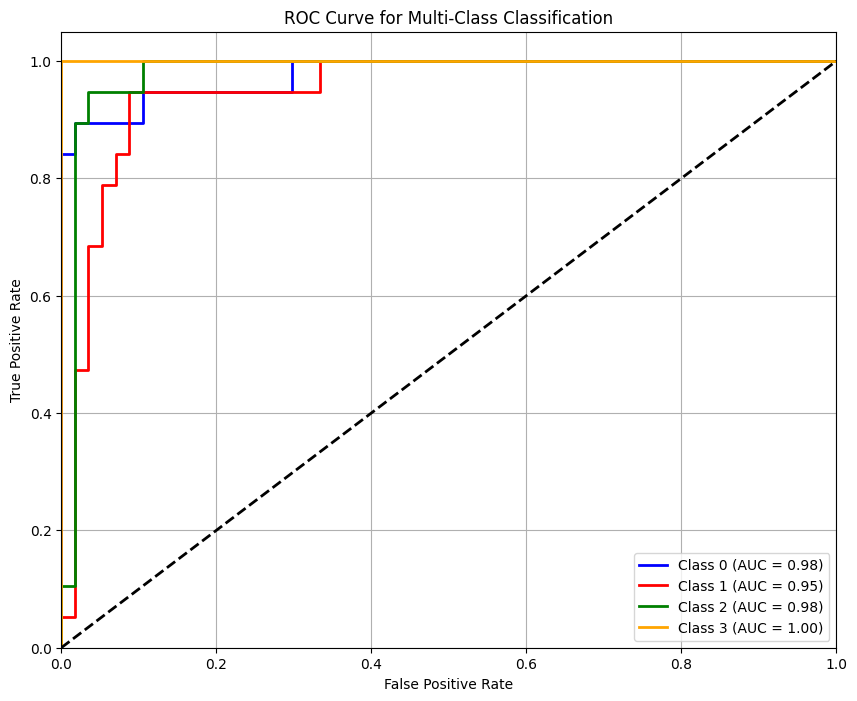

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(test_generator.class_indices)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the input layer with shape (224, 224, 3) for VGG16
input_layer = Input(shape=(224, 224, 3))

# Load the VGG16 model with pre-trained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the VGG16 base layers to prevent them from being trained initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensionality
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # First dense layer with L2 regularization
x = Dropout(0.5)(x)  # Dropout for additional regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)  # Second dense layer with L2 regularization
x = Dropout(0.5)(x)

# Output layer with softmax for multi-class classification (e.g., 10 classes)
output_layer = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Save the trained model in the .keras format (recommended for new Keras versions)
model.save('/content/drive/MyDrive/vggfinal_trained_model.keras')


In [ ]:
# Unfreeze some layers of VGG16 for fine-tuning
# We'll unfreeze the last 4 layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_modelVGG16_finetuned.keras', monitor='val_loss', save_best_only=True)

# Retrain the model with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks=[early_stopping, model_checkpoint]
)

# Extract the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Calculate the average training and validation accuracy
avg_train_acc = sum(train_acc) / len(train_acc)
avg_val_acc = sum(val_acc) / len(val_acc)

# Print the average accuracies
print(f"Average Training Accuracy over epochs: {avg_train_acc:.4f}")
print(f"Average Validation Accuracy over epochs: {avg_val_acc:.4f}")


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.8334 - loss: 0.4479 - val_accuracy: 0.7812 - val_loss: 0.4755
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.3150
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.8620 - loss: 0.4070 - val_accuracy: 0.7969 - val_loss: 0.4370
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.2800
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.8445 - loss: 0.3806 - val_accuracy: 0.8281 - val_loss: 0.3681
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 578ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.2628
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.8967 - loss: 0.3181 - val_accuracy: 0.8125 - val_loss: 0.3874
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.2411
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9000 - loss: 0.2937 

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


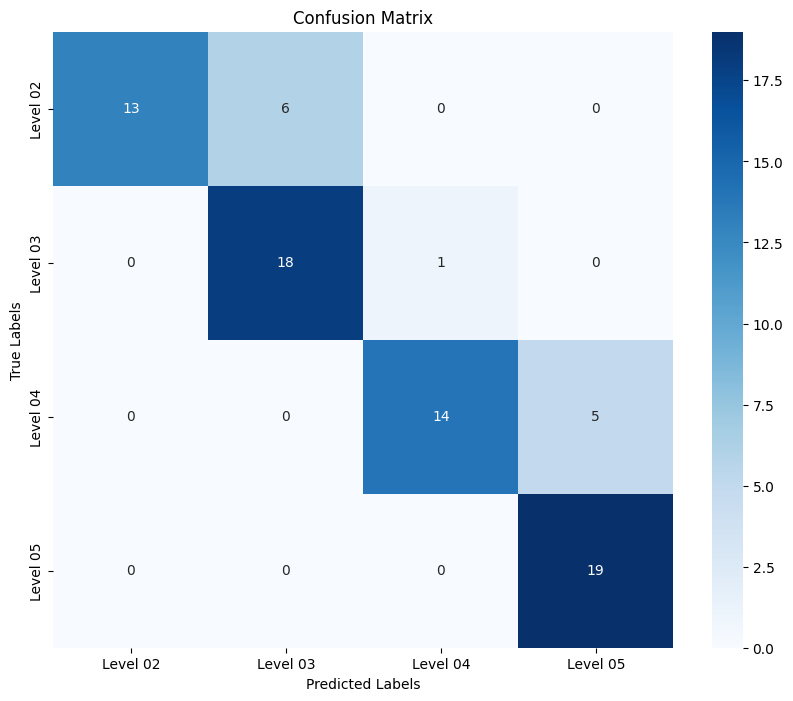

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class labels (for use in confusion matrix)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8750 - loss: 0.3710
Test Loss: 0.3569946885108948, Test Accuracy: 0.890625


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


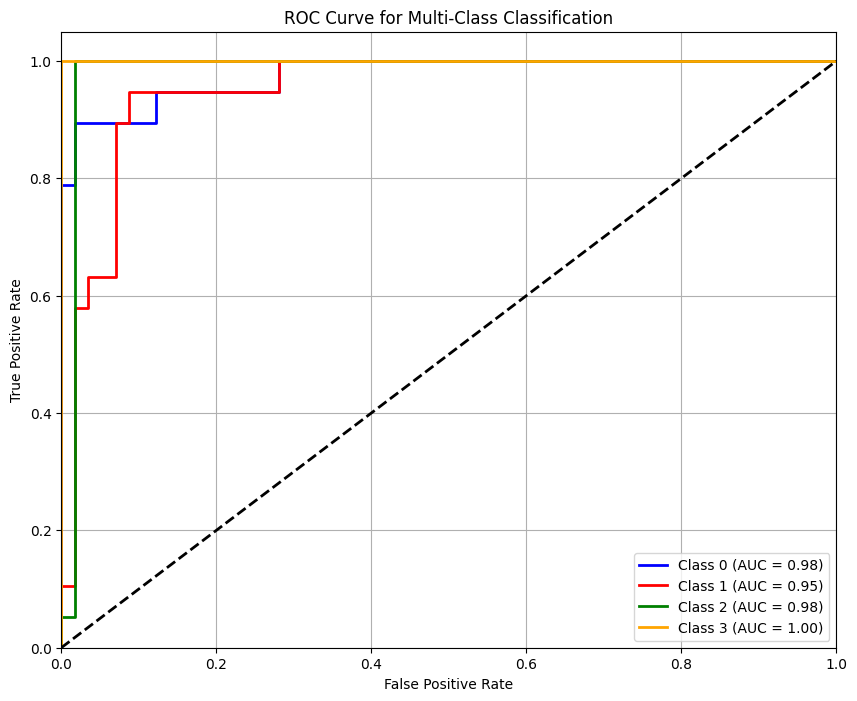

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(test_generator.class_indices)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Save the trained model in the .keras format (recommended for new Keras versions)
model.save('/content/drive/MyDrive/vggfinal1_trained_model.keras')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Define a mapping between model output indices and LCC levels
# This assumes that the model is trained to output in this order (2, 3, 4, 5)
LCC_LEVELS = {0: "Level 2", 1: "Level 3", 2: "Level 4", 3: "Level 5"}

# Load and preprocess a new image for prediction
img_path = '/content/drive/MyDrive/Soil Nitrogen Levels/Level 03/IMG_20210721_102748.jpg'  # Change to your image path
img = image.load_img(img_path, target_size=(224, 224))  # Load and resize image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
img_array /= 255.  # Normalize

# Predict the nitrogen level for the image
prediction = model.predict(img_array)

# Get the index of the highest predicted probability
predicted_class_index = np.argmax(prediction)

# Map the index to the corresponding nitrogen level
predicted_nitrogen_level = LCC_LEVELS[predicted_class_index]

# Output the result
print(f"Predicted Nitrogen Level: {predicted_nitrogen_level}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Nitrogen Level: Level 3


2/3 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


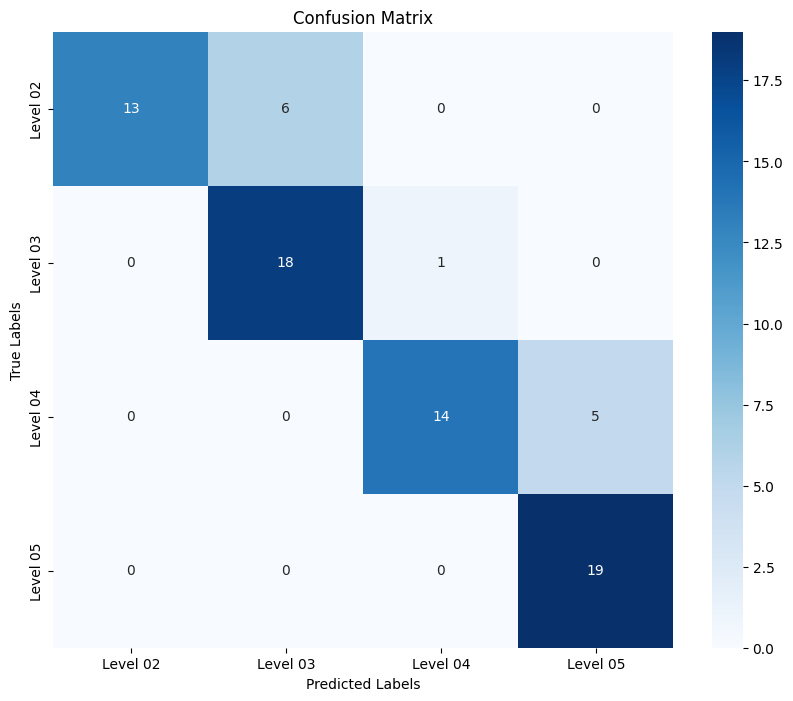

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class labels (for use in confusion matrix)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.8438 - loss: 0.3240
Test Loss: 0.30807340145111084, Test Accuracy: 0.859375


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the saved .keras file
model = load_model('/content/drive/MyDrive/vggfinal1_trained_model.keras)
'
# Verify that the model is loaded successfully by printing the summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 48,144,974 (183.66 MB)

 Trainable params: 13,503,236 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 27,006,474 (103.02 MB)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.8750 - loss: 0.3710
Test Loss: 0.3569946885108948, Test Accuracy: 0.890625


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Get true labels from test generator
true_labels = test_generator.classes

# Predict probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Display the classification report
print(report)

# Calculate the macro and weighted F1-scores
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the macro and weighted F1-scores
print(f"Macro F1-Score: {macro_f1}")
print(f"Weighted F1-Score: {weighted_f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
              precision    recall  f1-score   support

    Level 02       1.00      0.68      0.81        19
    Level 03       0.75      0.95      0.84        19
    Level 04       0.93      0.74      0.82        19
    Level 05       0.79      1.00      0.88        19

    accuracy                           0.84        76
   macro avg       0.87      0.84      0.84        76
weighted avg       0.87      0.84      0.84        76

Macro F1-Score: 0.8392399110807114
Weighted F1-Score: 0.8392399110807114


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the saved .keras file
model = load_model('/content/drive/MyDrive/vggfinal_trained_model.keras')

# Verify that the model is loaded successfully by printing the summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,986,126 (129.65 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,847,626 (49.01 MB)

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Get true labels from test generator
true_labels = test_generator.classes

# Predict probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Display the classification report
print(report)

# Calculate the macro and weighted F1-scores
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the macro and weighted F1-scores
print(f"Macro F1-Score: {macro_f1}")
print(f"Weighted F1-Score: {weighted_f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
              precision    recall  f1-score   support

    Level 02       1.00      0.68      0.81        19
    Level 03       0.75      0.95      0.84        19
    Level 04       0.94      0.79      0.86        19
    Level 05       0.83      1.00      0.90        19

    accuracy                           0.86        76
   macro avg       0.88      0.86      0.85        76
weighted avg       0.88      0.86      0.85        76

Macro F1-Score: 0.8529035160575859
Weighted F1-Score: 0.8529035160575859


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(test_generator.class_indices)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


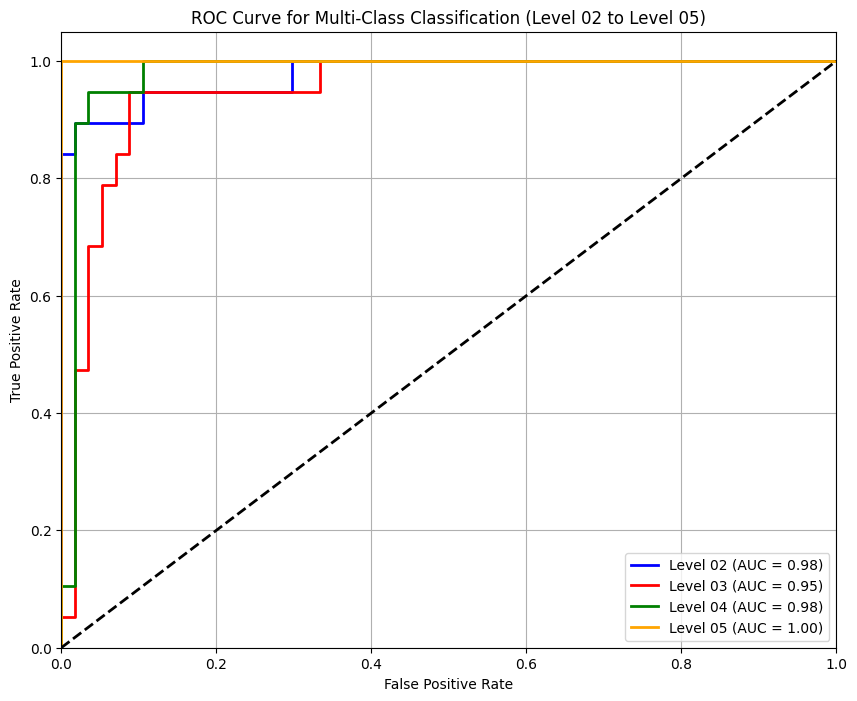

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Define the class labels (for use in plotting and binarization)
class_labels = ['Level 02', 'Level 03', 'Level 04', 'Level 05']

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(class_labels)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification (Level 02 to Level 05)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(test_generator.class_indices)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Calculate macro and weighted AUC
macro_auc = roc_auc_score(true_labels_bin, predictions, average='macro', multi_class='ovr')
weighted_auc = roc_auc_score(true_labels_bin, predictions, average='weighted', multi_class='ovr')

# Print the results
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Weighted AUC: {weighted_auc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step
Macro AUC: 0.9845
Weighted AUC: 0.9845
